# Imports

In [1]:
import peres_pyquil as pp
import peres_analysis as pa
import pickle
import numpy as np, matplotlib.pyplot as plt
from collections import Counter
import sys
import time
import multiprocessing as mp
Z_SCORE = 3
N_SHOTS = 10_000
import peres_pyquil_noise_models as ppnm
from scipy.optimize import curve_fit as cf
from pyquil import get_qc

# Selecting good qubits at the time of run

In [2]:
good_bits = pp.get_good_qbits(0.96, 0.96)#(0.97, 0.96)
for bits in good_bits:
    print(bits['Edge'].targets)
    print(bits['Qubit1'].gates[0])
    print(bits['Qubit2'].gates[0])
    print(bits['Edge'].gates[0], end='\n\n')
    

(20, 21)
MeasureInfo(operator='MEASURE', qubit=20, target='_', duration=2000, fidelity=0.982)
MeasureInfo(operator='MEASURE', qubit=21, target='_', duration=2000, fidelity=0.963)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9675354459264675)

(21, 36)
MeasureInfo(operator='MEASURE', qubit=21, target='_', duration=2000, fidelity=0.963)
MeasureInfo(operator='MEASURE', qubit=36, target='_', duration=2000, fidelity=0.981)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9722931966173082)

(23, 24)
MeasureInfo(operator='MEASURE', qubit=23, target='_', duration=2000, fidelity=0.972)
MeasureInfo(operator='MEASURE', qubit=24, target='_', duration=2000, fidelity=0.9789999999999999)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9698083744972107)

(35, 36)
MeasureInfo(operator='MEASURE', qubit=35, target='_', duration=2000, fidelity=0.97)
MeasureInfo(operator='MEASURE', qubit=36, 

Choose the best from the above list.

In [3]:
good_qubits = good_bits[3]

# Randomly selecting states for the run

In [4]:
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id
print(q1,q2)
trial = 1
iters = 25
states = [{'State_params': pa.params_complex()} for _ in range(iters)]

35 36


# Run on Aspen-9

In [57]:
engine = 'Aspen'
trial=2
try:
    states = pp.run_peres(q1, q2, trial, engine, states)
except Exception as e:
    print(e)

Engine requested: Aspen
Running Bell-state measurements
Done with iteration 19

Running Computational measurements
Creating folder product_peres_Aspen_2021-10-11_35_36_bits_10000_shots_trial_2
Results saved in file product_peres_Aspen_2021-10-11_35_36_bits_10000_shots_trial_2/result_list_trial_2

Completed.


Results of the output will be saved automatically.

In [58]:
with open(f'Result_final_redone_{tr}', 'wb') as file:
    pickle.dump([good_qubits,states], file)

In [48]:
with open(f'Result_final_redone_{2}', 'rb') as file:
    data = pickle.load(file)

good_qubits, states = data[0], data[1]
# Used for manuscript plot

In [19]:
with open('Result_one_shot_1', 'rb') as file:
    loaded = pickle.load(file)
good_qubits = loaded[0]
states = loaded[1]

with open('Result_one_shot_2', 'rb') as file:
    loaded = pickle.load(file)
good_qubits = loaded[0]
states = states + loaded[1]

In [3]:
with open("Result_3", 'rb') as file:
    data = pickle.load(file)

In [4]:
good_qubits = data[0]
states = data[1]

# Compute the Gamma values from Aspen-9

In [3]:
engine = 'Aspen'
states = pa.compute_gammas(states, engine)

In [ ]:
# with open('Result_{trial}', 'wb') as file:
#     pickle.dump(states, file)

# Run on ideal simulator

In [4]:
engine='2q-qvm'
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id
print(q1,q2)
trial=1
try:
    states = pp.run_peres(q1,q2,trial,engine,states)
except Exception as e:
    print(e)
# pp.run_peres(q1, q2, trial, engine, states)

23 24
Engine requested: 2q-qvm
Running Bell-state measurements
Done with iteration 24

Running Computational measurements
Creating folder product_peres_2q-qvm_2021-10-22_23_24_bits_10000_shots_trial_1
Results saved in file product_peres_2q-qvm_2021-10-22_23_24_bits_10000_shots_trial_1/result_list_trial_1

Completed.


# Compute the Gamma values from ideal simulator

In [5]:
engine = '2q-qvm'
states = pa.compute_gammas(states, engine)

# Run on noisy simulator

In [6]:
engine='2q-qvm-noisy'
# engine = 'noisy-Aspen'
amp_damp = 0.3
deph_damp = 1-good_qubits['Edge'].gates[0].fidelity
pmeas_1 = [good_qubits['Qubit1'].gates[0].fidelity, good_qubits['Qubit1'].gates[0].fidelity]
pmeas_2 = [good_qubits['Qubit2'].gates[0].fidelity, good_qubits['Qubit2'].gates[0].fidelity]
t1=0
t2=0

try:
    states = ppnm.run_peres(q1, q2, trial, engine, states, amp_damp, deph_damp, pmeas_1, pmeas_2, t1,t2)
except Exception as e:
    print(e)

Engine requested: 2q-qvm-noisy
Running Bell-state measurements
Done with iteration 24

Running Computational measurements
Creating folder product_peres_2q-qvm-noisy_2021-10-22_23_24_bits_10000_shots_trial_1
Results saved in file product_peres_2q-qvm-noisy_2021-10-22_23_24_bits_10000_shots_trial_1/result_list_trial_1

Completed.


# Compute Gamma values from noisy simulator

In [7]:
engine='2q-qvm-noisy'
states = pa.compute_gammas(states, engine)

# Computing the statistical fluctuations

In [8]:
def get_cfs(result_list, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_theory_cfs(result_list)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

def get_cfs_boot(result_list, engine, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_cfs_boot(result_list, engine)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

# Statistical fluctutions for ideal simulator

In [9]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs, args=(states[i*5:(i+1)*5], return_dict, i)) for i in range(5)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in range(5) for elem in return_dict[key]]

Started process 0.
Started process 1.
Started process 2.
Started process 3.
Started process 4.
Finished process 4 in 103.4875020980835 secs.
Finished process 3 in 107.50024938583374 secs.
Finished process 1 in 114.34601879119873 secs.
Finished process 2 in 115.67084240913391 secs.
Finished process 0 in 115.81733679771423 secs.


# Statistical fluctuations for Aspen-9

In [67]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs_boot, args=(states[i*5:(i+1)*5],'Aspen', return_dict, i)) for i in range(5)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in range(5) for elem in return_dict[key]]

Started process 0.
Started process 1.
Started process 2.
Started process 3.
Started process 4.
Finished process 4 in 0.0009350776672363281 secs.
Finished process 3 in 489.89374899864197 secs.
Finished process 2 in 496.6691777706146 secs.
Finished process 0 in 502.7953369617462 secs.
Finished process 1 in 505.17143726348877 secs.


# Statistical fluctuations for noisy simulator

In [10]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs_boot, args=(states[i*5:(i+1)*5],'2q-qvm-noisy', return_dict, i)) for i in range(5)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in range(4) for elem in return_dict[key]]

Started process 0.
Started process 1.
Started process 2.
Started process 3.
Started process 4.
Finished process 1 in 709.06596326828 secs.
Finished process 3 in 712.2399199008942 secs.
Finished process 0 in 719.6611495018005 secs.
Finished process 4 in 729.988183259964 secs.
Finished process 2 in 732.6290307044983 secs.


# Plotting the results

In [15]:
def fit_F(x,m,c):
    return m*x + c
    

In [71]:
# states = data
def plot_gs(select_states, gamma, file_prefix):
    fth = np.array([select_states[i]['Gammas_theory'][gamma] for i in range(len(select_states))])
    errth = np.array([select_states[i]['cfs_theory'][gamma] for i in range(len(select_states))])

    f2q = [select_states[i]['Gamma_2q-qvm'][gamma] for i in range(len(select_states))]

    fas = np.array([select_states[i]['Gamma_Aspen'][gamma] for i in range(len(select_states))])
    erras = np.array([select_states[i]['cfs_Aspen'][gamma] for i in range(len(select_states))])

    fnq = np.array([select_states[i]['Gamma_2q-qvm-noisy'][gamma] for i in range(len(select_states))])
    errnq = np.array([select_states[i]['cfs_2q-qvm-noisy'][gamma] for i in range(len(select_states))])
#     fnq = np.array([select_states[i]['Gamma_deph-qvm'][gamma] for i in range(len(select_states))])
#     errnq = np.array([select_states[i]['cfs_qvm'][gamma] for i in range(len(select_states))])


    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Helvetica"]})
#     fig = plt.figure(figsize=(15,5))
    # plt.subplot(2,2,4)
#     plt.errorbar(range(len(fnq)), (errnq[:,0]+errnq[:,1])/2, yerr=[(errnq[:,0]+errnq[:,1])/2 - errnq[:,0], errnq[:,1] - (errnq[:,0]+errnq[:,1])/2], ls='', marker = '', capsize=6, color='maroon', alpha=1, lw=1, label='Noisy-QVM')
#     plt.errorbar(range(len(fas)), (erras[:,0]+erras[:,1])/2, yerr=[(erras[:,0]+erras[:,1])/2 - erras[:,0], erras[:,1] - (erras[:,0]+erras[:,1])/2], ls='', marker = '', capsize=6, color='green', alpha=1, lw=1, label='Aspen-9')
    
    
    plt.plot(f2q, '*', color='blue', label='Ideal QVM')
    plt.errorbar(range(len(fth)), fth, yerr=[fth - errth[:,0], errth[:,1] - fth], ls='', marker = '', capsize=6, color='blue', alpha=1, lw=1, label='Statistical error-bar')
#     plt.plot(fas, 'o', color='darkgreen', label='Aspen-9')
#     plt.plot(fnq, 'D', color='maroon', label='Noisy QVM')
    plt.errorbar(range(len(fnq)), fnq, yerr=[fth - errth[:,0], errth[:,1] - fth], ls='', marker = 'D', capsize=6, color='maroon', alpha=1, lw=1, label='Noisy-QVM')
    plt.errorbar(range(len(fas)), fas, yerr=[fas - erras[:,0], erras[:,1] - fas], ls='', marker = 'o', capsize=6, color='darkgreen', alpha=1, lw=1, label='Aspen-9')
    plt.xticks(range(len(select_states)))
    plt.axhline(y=-1, ls='dashed', color='red')
    plt.axhline(y=1, ls='dashed', color='red')




#     plt.xlabel('Iterations', size=20)
    ylabs = {'a': '$\gamma_{12}$', 'b': '$\gamma_{23}$', 'c': '$\gamma_{31}$', 'F': '$F$'}
    plt.ylabel(ylabs[gamma], size=20)
    plt.xticks([],size=16)
    popt, pcov = None, None
    if gamma == 'F':
        x = np.arange(len(fas))
        popt, pcov = cf(fit_F, x, fas)
#         plt.plot(x, fit_F(x, *popt), ls='dashed', color='darkgreen', alpha=0.6, lw=4)

        popt, pcov = cf(fit_F, x, fnq)
#         plt.plot(x, fit_F(x, *popt), ls='dashed', color='maroon', alpha=0.6, lw=4)
        
        plt.yticks([-int(1), 0 , 1], size=16)
#         plt.yticks([-int(1), 0 , fit_F(popt[1], *popt), 1], size=16)
        print(popt)
        print(pcov)
        # residual sum of squares
        ss_res = np.sum((np.array(fnq) - fit_F(x, *popt)) ** 2)

        # total sum of squares
        ss_tot = np.sum((np.array(fnq) - np.mean(fth)) ** 2)

        # r-squared
        r2 = 1 - (ss_res / ss_tot)
        print(r2)

        
    else:
        plt.yticks([-1,0,1],size=18)
    
#     lgd = plt.legend(fontsize = 15, bbox_to_anchor=(1,1))

#     plt.savefig(f'{file_prefix}{gamma}.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    plt.legend(fontsize = 13, loc='lower left')
#     plt.legend(fontsize = 20, bbox_to_anchor=(1,1))
    plt.savefig(f'{file_prefix}{gamma}_22_Oct.pdf', bbox_inches='tight')
    
    plt.show()

[7.61301725e-05 8.13917325e-01]
[[ 7.80523629e-05 -4.29287219e-04]
 [-4.29287219e-04  3.29119606e-03]]
0.7875097028832008


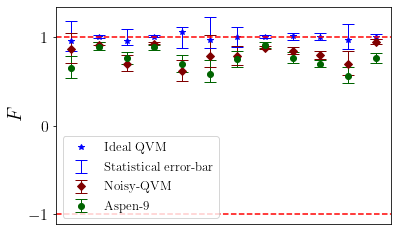

In [72]:
# which = np.random.choice(list(range(24)), size=10, replace=False)
# which = states[9:20]
# which = which[:3] + which[4:-4]
# states = [states[i] for i in which]
# plot_gs(states, 'F', 'Plot_for_manuscript')

In [73]:
engine = 'noisy-Aspen'
try:
    states = pp.run_peres(q1, q2, trial, engine, states)
except Exception as e:
    print(e)

name 'q1' is not defined


In [2]:
with open("Result_3", 'rb') as file:
    data = pickle.load(file)

good_qubits, states = data[0], data[1]

In [42]:
with open("results_aspen_theory_noisy_aspen9_errors.pkl", 'rb') as file:
    data = pickle.load(file)

good_qubits, states = data[0], data[1]

In [99]:
which = np.random.choice(list(range(24)), size=10, replace=False)

In [47]:
data[0]

{'State_params': [(1.601251295142588, 0.9794577683419738),
  (1.4479371099010032, 0.1550209549284421),
  (2.1657952926841006, 5.413668324854131)],
 'Counts_bell_2q-qvm': {'a': {'Clicks': array([[1, 0],
          [0, 1],
          [0, 0],
          ...,
          [1, 0],
          [0, 1],
          [0, 1]]),
   'Counts': Counter({'10': 1362, '01': 4297, '00': 3557, '11': 784})},
  'b': {'Clicks': array([[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 1],
          [1, 1]]),
   'Counts': Counter({'00': 3884, '01': 3746, '11': 1616, '10': 754})},
  'c': {'Clicks': array([[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 1],
          [0, 0],
          [1, 1]]),
   'Counts': Counter({'00': 4600, '01': 1899, '10': 501, '11': 3000})}},
 'Counts_comp_2q-qvm': {'a': {'Clicks': array([[1, 1],
          [0, 1],
          [1, 0],
          ...,
          [1, 1],
          [0, 0],
          [0, 1]]),
   'Counts': Counter({'11': 2225